# Labels Data Preprocessing

Organize your data like so

Tutorials I'm currently looking at

https://www.kaggle.com/asura93/full-preprocessing-tutorial/notebook

https://github.com/nishalpereira/CNN-for-Tumour-Classification

https://pythonprogramming.net/3d-convolutional-neural-network-machine-learning-tutorial/

In [1]:
import time
import matplotlib.pyplot as plt
from skimage import exposure,img_as_float
import cv2, os
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

In [2]:
csv_dir =os.path.dirname(os.getcwd())+'/CT_Project/'
csv_dir

'/Users/MOOSE/Desktop/DL/CT_Project/'

Check what directory your in, and change whatever future directories as well.

In [3]:
labels0_df = pd.read_excel('TCIA CTC no polyp found.xls')

labels0_df.rename(columns={'TCIA Patient ID':'TCIA Number'}, inplace=True)

labels1_df = pd.read_excel('TCIA CTC 6 to 9 mm polyps.xls')


labels2_df = pd.read_excel('TCIA CTC large 10 mm polyps.xls')


labels_df = pd.concat([labels0_df, labels1_df, labels2_df], axis=0, sort=True, ignore_index=True)

In [4]:
labels_df = labels_df.iloc[:,[0,7]]
labels_df.fillna(0, inplace=True)
labels_df.rename(columns={1.5:'Label'}, inplace=True)
labels_df

,TCIA Number,Label
0,1.3.6.1.4.1.9328.50.4.0001,0.0
1,1.3.6.1.4.1.9328.50.4.0003,0.0
2,1.3.6.1.4.1.9328.50.4.0004,0.0
3,1.3.6.1.4.1.9328.50.4.0005,0.0
4,1.3.6.1.4.1.9328.50.4.0006,0.0
5,1.3.6.1.4.1.9328.50.4.0009,0.0
6,1.3.6.1.4.1.9328.50.4.0010,0.0
7,1.3.6.1.4.1.9328.50.4.0011,0.0
8,1.3.6.1.4.1.9328.50.4.0012,0.0
9,1.3.6.1.4.1.9328.50.4.0013,0.0


In [5]:
# Get names of indexes for which column Age has value 16 98 88
indexNames = labels_df[(labels_df['Label'] == 16.0 )|(labels_df['Label'] == 88.0 )|(labels_df['Label'] == 98.0 )].index
# Delete these row indexes from dataFrame
labels_df.drop(indexNames , inplace=True)

labels_df['Class'] = np.where(labels_df['Label']==0.0
                              ,0,1)
labels_df

,TCIA Number,Label,Class
0,1.3.6.1.4.1.9328.50.4.0001,0.0,0
1,1.3.6.1.4.1.9328.50.4.0003,0.0,0
2,1.3.6.1.4.1.9328.50.4.0004,0.0,0
3,1.3.6.1.4.1.9328.50.4.0005,0.0,0
4,1.3.6.1.4.1.9328.50.4.0006,0.0,0
5,1.3.6.1.4.1.9328.50.4.0009,0.0,0
6,1.3.6.1.4.1.9328.50.4.0010,0.0,0
7,1.3.6.1.4.1.9328.50.4.0011,0.0,0
8,1.3.6.1.4.1.9328.50.4.0012,0.0,0
9,1.3.6.1.4.1.9328.50.4.0013,0.0,0


In [6]:
# Only include some for experimental use
####################################
# CT>10
# 1.3.6.1.4.1.9328.50.4.0040 
# 
# CT(6<polyp)
# 1.3.6.1.4.1.9328.50.4.0007 
# 
# 1.3.6.1.4.1.9328.50.4.0019 
# 1.3.6.1.4.1.9328.50.4.0043 
# 1.3.6.1.4.1.9328.50.4.0080 
# 
# CT(no polyp)
# 1.3.6.1.4.1.9328.50.4.0001 
# 1.3.6.1.4.1.9328.50.4.0003 
# 1.3.6.1.4.1.9328.50.4.0004 
# 1.3.6.1.4.1.9328.50.4.0005 
# 1.3.6.1.4.1.9328.50.4.0006 
####################################
experimentals=[
    "1.3.6.1.4.1.9328.50.4.0040",
    "1.3.6.1.4.1.9328.50.4.0007",
    "1.3.6.1.4.1.9328.50.4.0019",
    "1.3.6.1.4.1.9328.50.4.0043",
    "1.3.6.1.4.1.9328.50.4.0080",
    "1.3.6.1.4.1.9328.50.4.0001",
    "1.3.6.1.4.1.9328.50.4.0003",
    "1.3.6.1.4.1.9328.50.4.0004",
    "1.3.6.1.4.1.9328.50.4.0005",
    "1.3.6.1.4.1.9328.50.4.0006"]

In [7]:
labels_df_exp= labels_df.loc[labels_df['TCIA Number'].isin(experimentals)]
labels_df_exp

,TCIA Number,Label,Class
0,1.3.6.1.4.1.9328.50.4.0001,0.0,0
1,1.3.6.1.4.1.9328.50.4.0003,0.0,0
2,1.3.6.1.4.1.9328.50.4.0004,0.0,0
3,1.3.6.1.4.1.9328.50.4.0005,0.0,0
4,1.3.6.1.4.1.9328.50.4.0006,0.0,0
243,1.3.6.1.4.1.9328.50.4.0007,10.0,1
245,1.3.6.1.4.1.9328.50.4.0019,13.0,1
246,1.3.6.1.4.1.9328.50.4.0043,17.0,1
247,1.3.6.1.4.1.9328.50.4.0080,10.0,1
312,1.3.6.1.4.1.9328.50.4.0040,1.0,1


# DICOM Data Processing


## Making new file names (just from 1 to 11347 for now)

In [8]:
path= "/Users/MOOSE/Desktop/DL/CT_Project/CT_COLONOGRAPHY"
count = 1

for root, dirs, files in os.walk(path):
    for i in files:
        os.rename(os.path.join(root, i), os.path.join(root, "changed" + str(count) + ".dcm"))
        count += 1

In [9]:
count

10347

# Moving them to /data

In [97]:
src = '/Users/MOOSE/Desktop/DL/CT_Project/CT_COLONOGRAPHY'
dest = '/Users/MOOSE/Desktop/DL/CT_Project/data'

for path, subdirs, files in os.walk(src):
    for name in files:
        filename = os.path.join(path, name)
        shutil.copy2(filename, dest)

In [10]:
from glob import glob
data_path = "/Users/MOOSE/Desktop/DL/CT_Project/data/"
output_path = working_path = "/Users/MOOSE/Desktop/DL/CT_Project/"
g = glob(data_path + '*.dcm')

# Print out the first 5 file names to verify we're in the right folder.
print ("Total of %d DICOM images.\nFirst 5 filenames:" % len(g))
print ('\n'.join(g[:5]))

Total of 10824 DICOM images.
First 5 filenames:
/Users/MOOSE/Desktop/DL/CT_Project/data/changed757.dcm
/Users/MOOSE/Desktop/DL/CT_Project/data/changed3863.dcm
/Users/MOOSE/Desktop/DL/CT_Project/data/changed8936.dcm
/Users/MOOSE/Desktop/DL/CT_Project/data/changed8088.dcm
/Users/MOOSE/Desktop/DL/CT_Project/data/changed1912.dcm


In [17]:
total_slices = os.listdir(data_path)
len(total_slices)

10825

In [34]:
ds=pydicom.dcmread("/Users/MOOSE/Desktop/DL/CT_Project/data/changed757.dcm", force=True)
ds.PatientName

'1.3.6.1.4.1.9328.50.4.0006'

################# Stuck here.

In [35]:
list_patients=[]
for i in range(len(g)):
    ds=pydicom.dcmread(g[i], force=True)
    list_patients.append(ds.PatientName)

AttributeError: 'FileDataset' object has no attribute 'PatientName'

In [16]:
for patient in patients[:1]:
    label = labels_df_exp.get_value(patient, 'Class')
    path = data_dir + patient
    
    # a couple great 1-liners from: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(len(slices),label)
    print(slices[0])

/Users/MOOSE/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



KeyError: 'changed757.dcm'

Current Code

In [ ]:
pydicom.read_file(, force=True)

In [80]:
def readScan(fileList, imgType='DICOM', new_spacing=[5,1,1]):
    #Read a DICOM stack - fileList is a directory
    if imgType == 'DICOM':
        # Read in all of the slices
        slices = [pydicom.read_file(s) 
            for s in glob.glob(fileList + '/*.dcm')]
        slices.sort(key = lambda x: int(x.InstanceNumber))
        
        #Get the slice thickness and pixel spacing
        try:
            slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - 
                                     slices[1].ImagePositionPatient[2])
        except:
            slice_thickness = np.abs(slices[0].SliceLocation - 
                                     slices[1].SliceLocation)
        
        pixel_spacing = slices[0].PixelSpacing
        
        
        # Get the slope and intercept
        intercept = slices[0].RescaleIntercept
        slope = slices[0].RescaleSlope
        
        # Make them a numpy array
        image = np.stack([s.pixel_array for s in slices])
        image = image.astype(np.int16)
        
        # Set outside-of-scan pixels to air
        # The intercept is usually -1024, so air is approximately 0
        image[image < 0] = 0

        #Convert to Hounsfield units (HU)
        if slope != 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.int16)

        image += np.int16(intercept)

    #Read a NIFTI image - fileList is a file
#     elif imgType == 'NIFTI':
#         niftiData = nifti.load(fileList)
        
#         #Get the slice thickness and pixel spacing
#         slice_thickness = niftiData.header.get_zooms()[2]
#         pixel_spacing = list(niftiData.header.get_zooms()[:2])
        
#         # Get the slope and intercept
#         intercept = niftiData.dataobj.inter
#         slope = niftiData.dataobj.slope
        
#         #Get the actual image data
#         image = np.array(niftiData.dataobj)
#         #Shift the axis order to match what we expect (z,x,y) and
#         #adjust to (0,0) in the upper right
#         image = np.rollaxis(image, 2, 0)
#         image = np.fliplr(np.flipud(np.swapaxes(image,1,2)))

    # Calculate the desired resampling
    spacing = map(float, [slice_thickness] + list(pixel_spacing))
    spacing = np.array(list(spacing))
#     spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing))) 
#     spacing = np.array(list(map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))))
    resize_factor = spacing / new_spacing
    new_shape = np.round(image.shape * resize_factor)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    return scipy.ndimage.interpolation.zoom(image, real_resize_factor)

In [81]:
dataDir = '/Users/MOOSE/Desktop/DL/CT_Project/data'
outpath = "/Users/MOOSE/Desktop/DL/CT_Project/"
scan = readScan(dataDir, imgType='DICOM')
#processedScan = segmentationCrop(scan)
#np.savez_compressed(outpath + '/Image.npz', data=processedScan)

AttributeError: 'function' object has no attribute 'glob'

In [ ]:
scan.shape

In [57]:
data_dir = '/Users/MOOSE/Desktop/DL/CT_Project/data'
patients = os.listdir(data_dir)

for patient in patients[:1]:
    label = labels_df.get_value(patient, 'Label')
    path = data_dir + patient
    
    # a couple great 1-liners from: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(len(slices),label)
    print(slices[0])

/Users/MOOSE/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



KeyError: '000133.dcm'

In [42]:
labels3_df.columns

Index([        'TCIA Number', 'Slice# polyp Supine',  'Slice# polyp Prone',
                'LESION 1.1',                   1.2,                   1.3,
                         1.4,                   1.5,          'LESION 2.1',
                         2.2,                   2.3,                   2.4,
                         2.5,          'LESION 3.1',                   3.2,
                         3.3,                   3.4,                   3.5,
                'LESION 4.1',                   4.2,                   4.3,
                         4.4,                   4.5],
      dtype='object')

In [10]:
def dicom_2png(file):
    _currFile = file
    dcm = pydicom.dcmread(file)
    fileName = os.path.basename(file)
    imageX = dcm.pixel_array
    temp = imageX.copy()
    print("shape ----", imageX.shape)
    picMax = imageX.max()
    vmin = imageX.min()
    vmax = temp[temp < picMax].max()
    # print("vmin : ", vmin)
    # print("vmax : ", vmax)
    imageX[imageX > vmax] = 0
    imageX[imageX < vmin] = 0
    # result = exposure.is_low_contrast(imageX)
    # # print(result)
    image = img_as_float(imageX)
    plt.cla()
    plt.figure('adjust_gamma', figsize=(10.24, 10.24))
    plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0, wspace=0)
    plt.imshow(image, 'gray')
    plt.axis('off')
    plt.savefig(fileName + '.png')
    time.sleep(1)


shape ---- (512, 512)


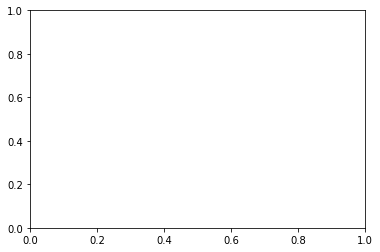

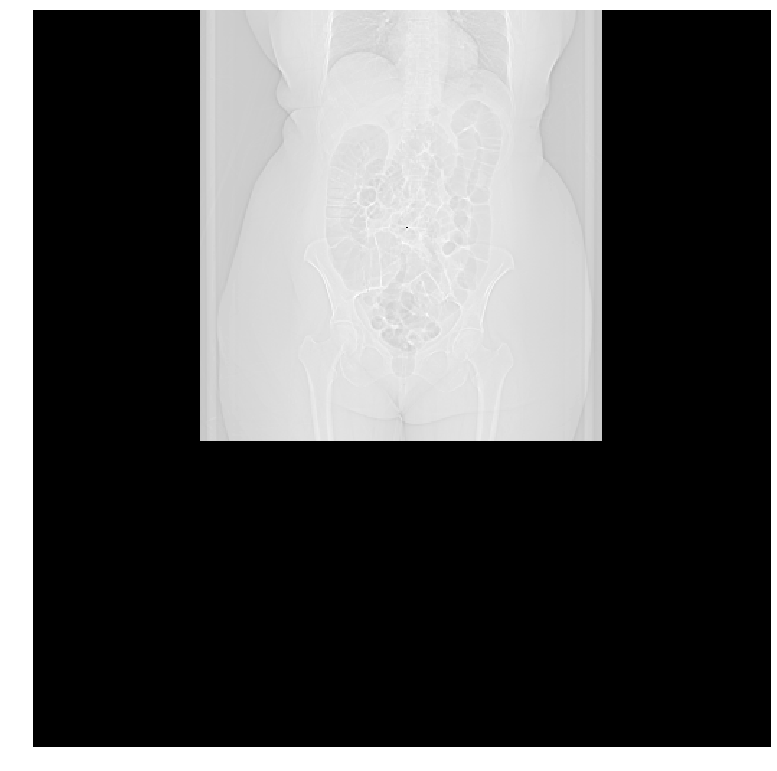

In [11]:
dicom_2png('./000000.dcm')

In [37]:
from skimage import exposure
import os
import pydicom
import math
import random
import numpy
import matplotlib.pyplot as plt
import time

def imageCount(dirName):
    """Counts the number of files in a directory
    Counts the number of files in a given directory and returns the result. Ignores desktop.ini to allow for Windows compatibility
    Args:
        dirName: A string representation of the name of the directory to be opened. This directory should be a child of the working directory. EX: "trainingImages"
    Returns:
        An integer value for the number of files in the directory
    """

    for root, dir, files in os.walk("./" + dirName):
        scans = [file  for file in files if file != "desktop.ini"]
        return len(scans)
    print(dirName + " is not a valid directory")
    exit(-1)

def readScan(scanNum, dirName):
    """ Reads a DICOM file from a directory
    Given a directory name and the number of the file containing the image to be read, reads in and returns a numpy representation of the image. Also normalizes the pixel values of the image.
    Args:
        scanNum: An integer containing the one-based index of the file to be read
        dirName: A string representation of the name of the directory to be opened. This directory should be a child of the working directory. Ex: "trainingImages"
    Returns: 
        A numpy array containing the pixel data for the image
    """

    for root, dir, files in os.walk("./" + dirName):
        scans = [file  for file in files if file != "desktop.ini"]
        print("Reading image " + scans[scanNum] + " from " + dirName)
        data = numpy.load("./" + dirName + "/" + scans[scanNum])
        #plt.imshow(data)
        #plt.show()
        data = exposure.equalize_adapthist(data)        
        #plt.imshow(data)
        #plt.show()
        return data
    print(dirName + " is not a valid directory")
    exit(-1)

def readValidationImages():
    """ Reads in all images in the validation directories
    Creates a numpy array containing the pixel data of all the images in the directories of validation images. Assumes that the subdirectories "PosVal" and "NegVal" exit in the working directory
    
    Args: None
    Returns: 
        A numpy array containing the pixel values for all validation images. Also returns a numpy array containing whether each image has a positive or negative label
    """
    
    labels = []
    patientData = []
    
    for i in range(0,imageCount("PosVal")):
        data = readScan(i, "PosVal")
        labels.append(1)
        patientData.append(data)
    for i in range(0,imageCount("NegVal")):
        data = readScan(i, "NegVal")
        labels.append(0)
        patientData.append(data)

    patientData = numpy.stack(patientData).astype(float)

    return patientData, numpy.stack(labels)

def readBatch(batchSize):
    """ Reads in a batch of images
    Given a batch size, reads a group of images at random containing an eqaul number of positive and negative examples. Assumes the directories "posTrain" and "negTrain" exist
    Args: 
        batchSize: An integer containing the total number of images to read. batchSize // 2 images will be read from the positive and negative training directories
    Returns:
        A numpy array containing the pixel values for the batch of images. Also returns a numpy array containing whether each image has a positive or negative label
    """

    labels = []
    patientData = []
    
    posLen = imageCount("PosTrain")
    negLen = imageCount("NegTrain")

    posStart = random.randint(0,(posLen- (batchSize//2)) - 1)
    negStart = random.randint(0,(negLen- (batchSize//2)) - 1)

    for i in range(batchSize //2):
        data = readScan(posStart + i, "PosTrain")
        labels.append(1)
        patientData.append(data)
        data = readScan(negStart + i, "NegTrain")
        labels.append(0)
        patientData.append(data)
    
    patientData = numpy.stack(patientData).astype(float)
    return patientData, numpy.stack(labels)

def normReadAll():
    """ Reads all images in the training set
    Reads all images from the training set. Assumes that the working directory has subdirectories "PosTrain" and "NegTrain"
    Returns:
        A numpy array containing the pixel values for the batch of images. Also returns a numpy array containing whether each image has a positive or negative label
    """
    
    labels = []
    patientData = []
    
    posLen = imageCount("PosTrain")
    negLen = imageCount("NegTrain")

    for i in range(posLen):
        data = readScan(i, "PosTrain")
        labels.append(1)
        data = exposure.equalize_adapthist(data)        
        patientData.append(data)
    for i in range(negLen):
        data = readScan(i, "NegTrain")
        labels.append(0)
        data = exposure.equalize_adapthist(data)        
        patientData.append(data)
    
    patientData = numpy.stack(patientData).astype(float)
    return patientData, numpy.stack(labels)

def readTest():
    """ Reads all images in the test set
    Reads all images from the test set. Assumes that the working directory has subdirectories "PosTest" and "NegTest"
    Returns:
        A numpy array containing the pixel values for the batch of images. Also returns a numpy array containing whether each image has a positive or negative label
    """
    labels = []
    patientData = []
    
    posLen = imageCount("PosTest")
    negLen = imageCount("NegTest")

    for i in range(posLen):
        data = readScan(i, "PosTest")
        labels.append(1)
        data = exposure.equalize_adapthist(data)        
        patientData.append(data)
    for i in range(negLen):
        data = readScan(i, "NegTest")
        labels.append(0)
        data = exposure.equalize_adapthist(data)        
        patientData.append(data)
    
    patientData = numpy.stack(patientData).astype(float)
    return patientData, numpy.stack(labels)
    

In [38]:
dirName='/Users/MOOSE/Desktop/DL/CT_Project/'
imageCount(dirName)

/Users/MOOSE/Desktop/DL/CT_Project/ is not a valid directory
